<a href="https://colab.research.google.com/github/af001/Predictive-Analytics/blob/master/MSDS422/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


[+] Boston DataFrame (first and last five rows):
  neighborhood     crim    zn  indus  chas  ...  rad  tax  ptratio  lstat    mv
0       Nahant  0.00632  18.0   2.31     0  ...    1  296     15.3   4.98  24.0
1   Swampscott  0.02731   0.0   7.07     0  ...    2  242     17.8   9.14  21.6
2   Swanpscott  0.02729   0.0   7.07     0  ...    2  242     17.8   4.03  34.7
3   Marblehead  0.03237   0.0   2.18     0  ...    3  222     18.7   2.94  33.4
4   Marblehead  0.06905   0.0   2.18     0  ...    3  222     18.7   5.33  36.2

[5 rows x 14 columns]
    neighborhood     crim   zn  indus  chas  ...  rad  tax  ptratio  lstat    mv
501     Winthrop  0.06263  0.0  11.93     0  ...    1  273     21.0   9.67  22.4
502     Winthrop  0.04527  0.0  11.93     0  ...    1  273     21.0   9.08  20.6
503     Winthrop  0.06076  0.0  11.93     0  ...    1  273     21.0   5.64  23.9
504     Winthrop  0.10959  0.0  11.93     0  ...    1  273     21.0   6.48  22.0
505     Winthrop  0.04741  0.0  11.93     

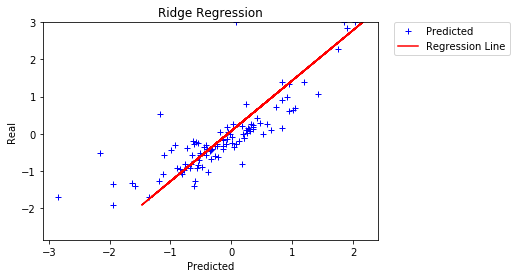

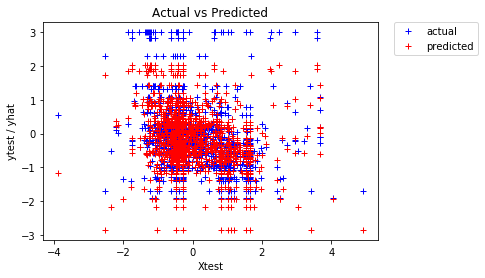

<Figure size 432x288 with 0 Axes>

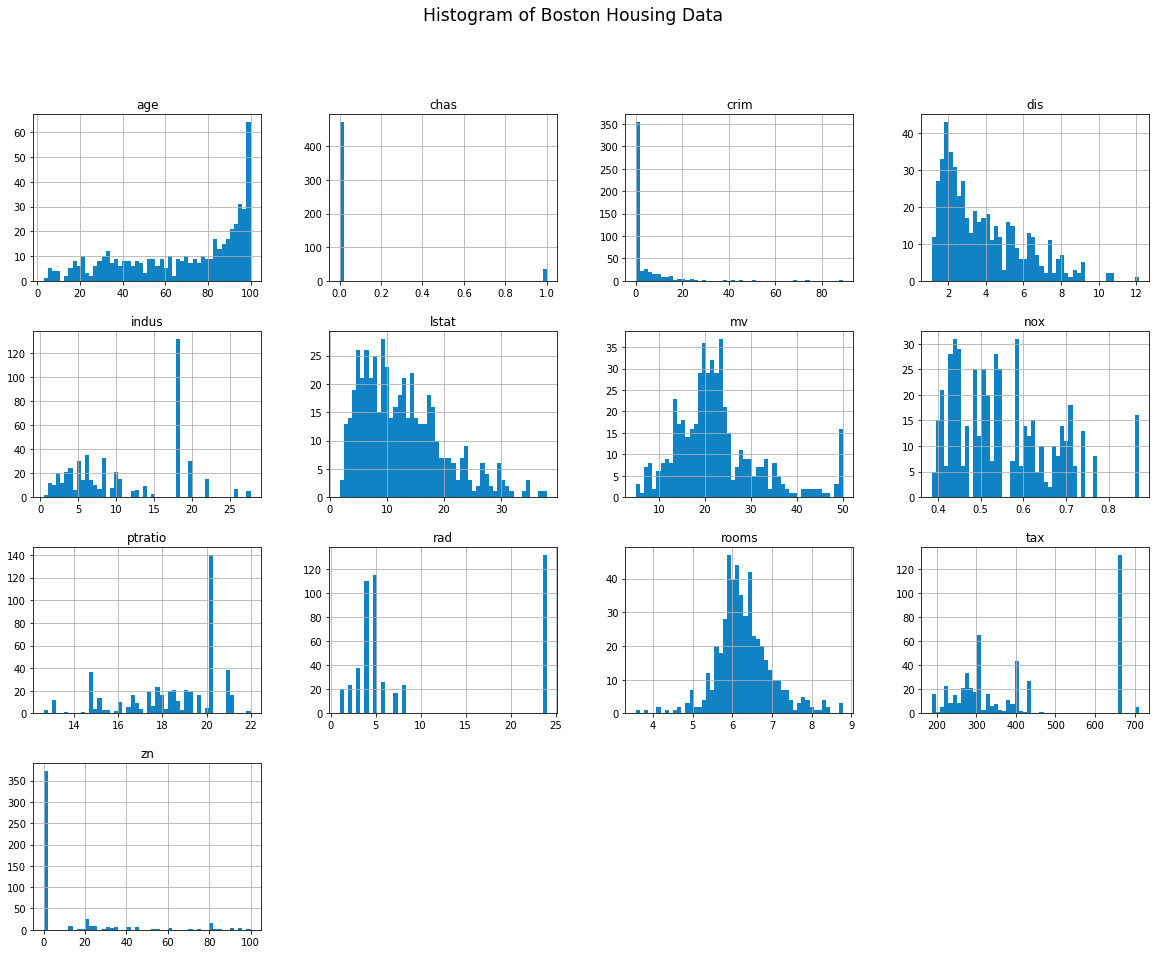

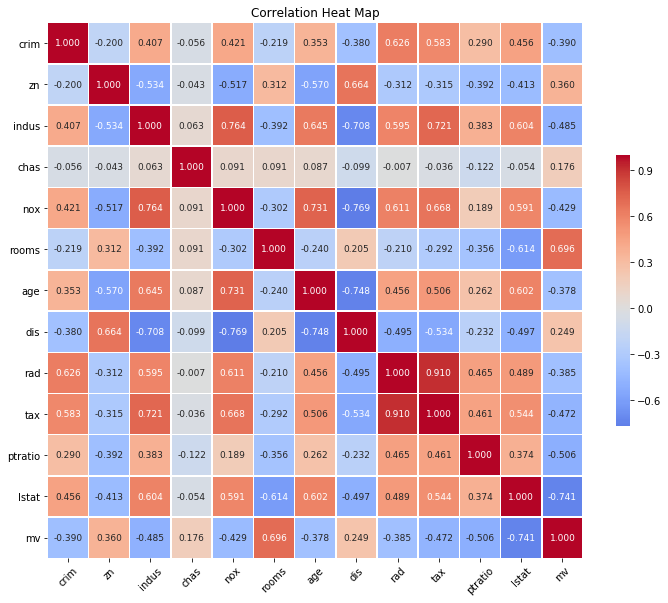

In [7]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: Anton
@date 10/06/17
"""

#<!---------Import / Set Variables Section----------!>
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score  
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from math import sqrt  

# function that accepts two variables: alpha and name. Both values represent
# the alpha and regression method beint tested. Return the model with the
# appropriate parameters set. 
def get_model(a, name):
    if name == 'Linear':
        model = LinearRegression(fit_intercept = SET_FIT_INTERCEPT)
    elif name == 'Ridge':
        model = Ridge(alpha = a, solver = 'cholesky', 
                      fit_intercept = SET_FIT_INTERCEPT, 
                      normalize = False, 
                      random_state = RANDOM_SEED)
    elif name == 'Lasso':
        model = Lasso(alpha = a, max_iter=10000, tol=0.01, 
                      fit_intercept = SET_FIT_INTERCEPT, 
                      random_state = RANDOM_SEED)
    elif name == 'ElasticNet':
        model = ElasticNet(alpha = a, l1_ratio = 0.5, 
                           max_iter=10000, tol=0.01, 
                           fit_intercept = SET_FIT_INTERCEPT, 
                           normalize = False, 
                           random_state = RANDOM_SEED)
    return model

# function that accepts a pandas dataframe to generate a seaborn heatmap
# that can be used to identify correlations between variables
def corr_chart(df_corr):
    corr=df_corr.corr()
    plt.figure(num=2, figsize=(12, 10))
    sns.heatmap(corr, cmap='coolwarm',
        center = 0, square=True,
        linewidths=.5, cbar_kws={'shrink':.5},
        annot = True, annot_kws={'size': 9}, fmt = '.3f')
    plt.xticks(rotation=45) # rotate variable labels on columns (x axis)
    plt.yticks(rotation=0) # use horizontal variable labels on rows (y axis)
    plt.title('Correlation Heat Map')
    plt.savefig('plot-corr-map.pdf',
        bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b',
        orientation='portrait', papertype=None, format=None,
        transparent=True, pad_inches=0.25, frameon=None)

# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 42

# Modified from 10-fold to max folds. Resulted in lower RMSE
N_FOLDS = 10

# establish a list of regression methods
NAMES = ['Linear', 'Ridge', 'Lasso', 'ElasticNet'] 

# although we standardize X and y variables on input,
# we will fit the intercept term in the models
# Expect fitted values to be close to zero
SET_FIT_INTERCEPT = True

# set print options for diagrams
np.set_printoptions(precision=3)

# read in the boston housing data from a csv in the same path
boston_input = pd.read_csv('boston.csv')

#<!---------Data Organization / Cleaning Section----------!>

# check the pandas DataFrame object boston_input
print '\n[+] Boston DataFrame (first and last five rows):'
print boston_input.head()
print boston_input.tail()

print '\n[+] General description of the boston_input DataFrame:'
print boston_input.info()

# drop neighborhood from the data being considered, convert ints to floats
boston = boston_input.drop('neighborhood', 1)
boston.chas = pd.to_numeric(boston.chas, downcast='float')
boston.rad = pd.to_numeric(boston.rad, downcast='float')
boston.tax = pd.to_numeric(boston.tax, downcast='float')

print '\n[+] General description of the boston DataFrame:'
print boston.info() 

print '\n[+] Descriptive statistics of the boston DataFrame:' 
print boston.describe() 

# set up preliminary data for data for fitting the models 
# the first column is the median housing value response
# the remaining columns are the explanatory variables
prelim_model_data = np.array([   
        boston.mv,
        boston.crim,
        boston.zn,
        boston.indus,
        boston.chas,
        boston.nox,
        boston.rooms,
        boston.age,
        boston.dis,
        boston.rad,
        boston.tax,
        boston.ptratio,
        boston.lstat,]).T

# dimensions of the polynomial model X input and y response
# preliminary data before standardization
print '\n[+] Data dimensions:', prelim_model_data.shape

# standard scores for the columns... along axis 0
scaler = StandardScaler()
print scaler.fit(prelim_model_data)

# show standardization constants being employed
print scaler.mean_
print scaler.scale_

# the model data will be standardized form of preliminary model data
model_data = scaler.fit_transform(prelim_model_data)

# dimensions of the polynomial model X input and y response
# all in standardized units of measure
print '\n[+] Dimensions for model_data:', model_data.shape 

#<!---------Evaluation Section----------!>

# split the data into training / test sets using 80/20 split. Compare
# against the 10-fold
train_set, test_set = train_test_split(model_data, test_size=0.2, 
                                       random_state=RANDOM_SEED)

# for 80/20 split, the first value [0] is the response, or y 
Xtrain = train_set[:, 1:train_set.shape[1]]
ytrain = train_set[:, 0]
Xtest = test_set[:, 1:test_set.shape[1]]
ytest = test_set[:, 0]

# create a dict that holds the lowest RMSE based on the alpha value
best_alpha = {}
cv_results = {}

# start comparing methods using various parameter
name_index = 0
for name in NAMES:
    print '\n[+] Alpha evaluation for: ', name 
    print 'alpha\t RMSE_train\t RMSE_10cv'
    
    # create a range of alpha values 
    alpha = np.linspace(.01,20,50)
    
    # for loop to test each regression method using a different alpha
    for a in alpha:
        model = get_model(a, name)
        
        # computing the RMSE on training data of the 80/20 split set
        model.fit(Xtrain, ytrain)
        p = model.predict(Xtest)
        rmse_train = sqrt(mean_squared_error(ytest, p))
            
        # compute RMSE using 10-fold cross validation
        kf = KFold(n_splits = N_FOLDS, shuffle=False, 
                   random_state = RANDOM_SEED)
        
        # train / test using each method, using different alphas. Separate 
        # training / test data for each fold, fit the data, and predict. Store
        # values in a variable to obtain the mean across folds
        value_holder = []
        for train, test in kf.split(model_data):
            X_train = model_data[train, 1:model_data.shape[1]]
            X_test = model_data[test, 1:model_data.shape[1]]
            y_train = model_data[train, 0]
            y_test = model_data[test, 0]  
            
            model.fit(X_train, y_train)
            yhat = model.predict(X_test)
            fold_method_result = sqrt(mean_squared_error(y_test, yhat))
            value_holder.append(fold_method_result)
        
        # calculate the mean value from the results of the each fold
        mean_fold = sum(value_holder)/N_FOLDS
        
        # store the best alpha and lowest RMSE in a python dict. If a value is
        # better for eather variable, modify the dict to hold new values.
        if name not in cv_results:
            cv_results[name] = mean_fold
            best_alpha[name] = a
        else:
            if mean_fold < cv_results[name]: 
                 cv_results[name] = mean_fold
                 best_alpha[name] = a
        
        # print individual results for the regression method based on alpha
        # values
        print('{:.3f}\t {:.4f}\t\t {:.4f}'.format(a,rmse_train, mean_fold))

# convert results to a dataframe. Record best method from the values available
# in the row. Print best method to stdout.
cv_results_df = pd.DataFrame(cv_results, index=[0])
best_method = cv_results_df.idxmin(axis=1).values[0]

print '\n[+] Average RMSE:\n', cv_results_df.to_string(index=False)

#<!-------------------Analyze Best Method-------------------->

print '\n[+] Best Method: ', best_method

# get the best method and best alpha. Re-train and predict based on the 80/20
# split. Generate visualizations from the results.
model = get_model(best_alpha[best_method], best_method)
model.fit(Xtrain, ytrain)
yhat = model.predict(Xtest)

# provide details on the chosen method; including intercept, coefficient
# variance, RMSE; include parameters of the chosen method.
print '[+] Fitted regression intercept:', model.intercept_
print '[+] Fitted regression coefficients:', model.coef_
print '[+] Coefficient of determination (R-squared):', r2_score(ytest, yhat)

fold_method_result = sqrt(mean_squared_error(ytest, yhat))
print '[+] Model Params: ', model.get_params(deep=True)
print '[+] Root mean-squared error:', fold_method_result

# calculate the regression line
slope, intercept = np.polyfit(ytest, yhat, 1)
abline_values = [slope * i + intercept for i in ytest]

# plot actual and expected values; plot the regression line
plt.figure(1)
plt.title('{} Regression'.format(best_method))
plt.plot(yhat, ytest, 'b+', label='Predicted')
plt.plot(abline_values, ytest, 'r', label='Regression Line')
plt.xlabel("Predicted")
plt.ylabel("Real")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim([np.min(yhat), np.max(ytest)])
plt.savefig('plot-reg.pdf',
            bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b',
            orientation='portrait', papertype=None, format=None,
            transparent=True, pad_inches=0.25, frameon=None)

# plot the relationship between predicted and actual values
plt.figure(2)
plt.title('Actual vs Predicted')
plt.xlabel("Xtest")
plt.ylabel("ytest / yhat")
plt.plot(Xtest, ytest, 'b+', label='actual')
plt.plot(Xtest, yhat, 'r+', label='predicted')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), 
           loc=2, borderaxespad=0.)
plt.savefig('plot-actual-predict.pdf',
            bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b',
            orientation='portrait', papertype=None, format=None,
            transparent=True, pad_inches=0.25, frameon=None)

plt.figure(3)
boston.hist(bins=50, figsize=(20,15), color='#1182c4')
plt.suptitle('Histogram of Boston Housing Data', ha='center', 
             fontsize='xx-large')
plt.savefig('boston-histogram.pdf',
    bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b',
    orientation='portrait', papertype=None, format=None,
    transparent=False, pad_inches=0.25, frameon=None)

# show the matplotlib plots
plt.show()

# expore additional correlations using seaborn heatmap
corr_chart(boston)